<a href="https://colab.research.google.com/github/luizfreire96/Wind-energy-data-curve-fit/blob/main/prediction_of_wind_speed_using_weibull_PDF_and_ARMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to forecast wind speed in another project, it is important to analyze the data to select the best model for predictions. In this project we will analyze the data and try to find the best distribution curve for fitting the data, such as Weibull or Normal. The Data used is the same used in **Yu Ding book, Data Science for Wind Energy.**

#Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min
from scipy.stats import chi2
import matplotlib.pyplot as plt

#Importing data

In [125]:
df = pd.read_csv('https://raw.githubusercontent.com/luizfreire96/Wind-energy-data-curve-fit/main/Wind%20Time%20Series%20Dataset(10min).csv')

#Taking a brief look at the data

In [3]:
df.head()

,Time,WindSpeed,Power
0,2014-10-07 01:20:00,8.22,40.526173
1,2014-10-07 01:30:00,8.09,38.552540
2,2014-10-07 01:50:00,7.21,21.313683
3,2014-10-07 02:00:00,6.75,18.031418
4,2014-10-07 02:10:00,6.52,16.593281


In [4]:
df.describe()

,WindSpeed,Power
count,39195.000000,39195.000000
mean,6.863497,30.415774
std,2.065032,26.069511
min,0.090000,-0.007123
25%,5.370000,9.727654
50%,6.670000,22.314745
75%,8.070000,44.854827
max,19.790000,100.000000


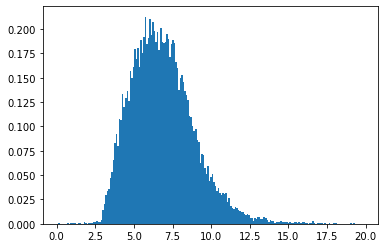

In [5]:
hist = plt.hist(df['WindSpeed'], 200, density=True)

## *WEIBULL FIT*

In [6]:
 #The method below will estimate the parameters of the Weibull distribution.
 #It uses the Maximum Likelihood Estimator for this.
weibull = weibull_min.fit(df['WindSpeed'])

#Attributing the values for each variable we have beta, gamma and alpha respectively.
wshape, wloc, wscale = weibull[0], weibull[1], weibull[2]

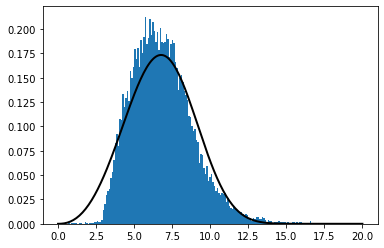

In [7]:
 #This create the distribution object.
x = np.linspace(0.01, 20, 200)
dist = weibull_min.pdf(x, wshape, scale=wscale) 

#Plotting the histogram and the curve to see how it fits, but a test will be needed anyway.
plt.plot(x, dist, 'k-', lw=2, label='frozen pdf')
plt.hist(df.WindSpeed, 200, density=True)
plt.show()

In [8]:
#copying just to don't mess up the original DataFrame
df2 = df.copy()

###Testing how good this fit is

We will use the chi square test to see if the parameters of weibull fit are good enourgh, assuming a p-value of 0.05, that means the 95% of values of the fit fall in the same bin of the actual measurements.

In [9]:
df_copy = df.copy()
df_copy['Month'] = df['Time'].str[5:7]
df_copy.head()

,Time,WindSpeed,Power,Month
0,2014-10-07 01:20:00,8.22,40.526173,10
1,2014-10-07 01:30:00,8.09,38.552540,10
2,2014-10-07 01:50:00,7.21,21.313683,10
3,2014-10-07 02:00:00,6.75,18.031418,10
4,2014-10-07 02:10:00,6.52,16.593281,10


In [10]:
df_nov = df_copy.query('Month == "11"')

In [11]:
df_nov.describe()

,WindSpeed,Power
count,3192.000000,3192.000000
mean,7.190216,36.328200
std,2.133270,28.876470
min,2.120000,0.021368
25%,5.560000,11.027384
50%,7.160000,29.237354
75%,8.660000,57.533865
max,15.120000,99.589474


In [12]:
#grouping velocities in 0.1 m/s width bins
bins01 = [i/10 for i in range (0, 200, 1)]
labels1 = [i/10 for i in range (1, 200, 1)]
df_nov01 = df_nov.copy()
df_nov01['Windspeedbin'] = pd.cut(df_nov['WindSpeed'], bins01, labels=labels1)

In [13]:
#Counting the frequencies of each bin
df_grouped01 = df_nov01.groupby(['Windspeedbin'], as_index=False).count()

In [14]:
#A chi2 test will be used. When the frequencies are low, say, lower than 5,
#its better group with other bins to minimize discrepancies between observed and expected data
#Then we group bins until frequencies turn into 5 or higher

df_test01 = df_grouped01.copy()
drop_that_after = []
for i in range (1, len(df_test01['WindSpeed']), 1):
  if df_test01['WindSpeed'].iloc[i-1] < 5:
    df_test01['WindSpeed'].iloc[i] = df_test01['WindSpeed'].iloc[i] + df_test01['WindSpeed'].iloc[i-1]
    drop_that_after.append(i-1)
df_test01 = df_test01.drop(df_test01.index[drop_that_after])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
df_test01.head()

,Windspeedbin,Time,WindSpeed,Power,Month
24,2.5,3,6,3,3
26,2.7,2,6,2,2
29,3.0,11,15,11,11
30,3.1,16,16,16,16
31,3.2,18,18,18,18


In [16]:
#Calculating the density for each bin, after that just mutiply to obtain the expected frequency
f_exp = []
for a in range(1, len(df_test01.Windspeedbin), 1):
  f_exp.append(weibull_min.cdf(df_test01.iloc[a]['Windspeedbin'], wshape, scale=wscale)-weibull_min.cdf(df_test01.iloc[a-1]['Windspeedbin'], wshape, scale=wscale))

In [17]:
f_obs = [i for i in df_test01['WindSpeed']]
f_exp = [i*3192 for i in f_exp]

In [18]:
print(f_obs[0])
print(f_obs[len(f_obs)-1])

6
0


In [19]:
f_obs.pop()

0

In [20]:
#chi square is a value that represent the error
wchisqr = 0
for i in range(0, len(f_exp), 1):
  wchisqr = wchisqr + (f_obs[i]-f_exp[i])**2/f_exp[i]
wchisqr

649.4241670196036

In [21]:
#The null hypothesis is that the fit is good enough and we will accept it on p-value > 0.05
p_value = 1 - chi2.cdf(x=wchisqr, df=(len(f_obs)-2-1))
print(p_value)

0.0


As we see the va value of chi-square is too high and the p-value is almost 0, then the null hypothesis is rejected. Let's what happens if we change chi-square to a critical value of chi-square

In [22]:
critical_chi = chi2.ppf(q=0.95, df=(len(f_obs)-2-1))
p_value_critical = 1 - chi2.cdf(x=critical_chi, df=(len(f_obs)-2-1))
print(p_value_critical, critical_chi)

0.04999999999999993 117.63165114234555


Lets see what happens if we how the november month data looks like

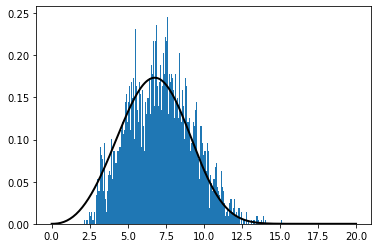

In [23]:
plt.plot(x, dist, 'k-', lw=2, label='frozen pdf')
plt.hist(df_nov.WindSpeed, 200, density=True)
plt.show()

lets try to fit a new curve using only the november data

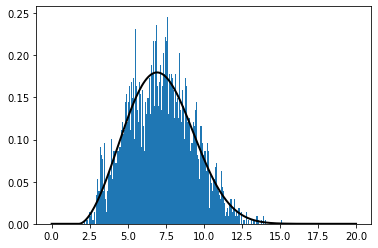

In [24]:
weibull_nov = weibull_min.fit(df_nov.WindSpeed) 
wnshape, wnloc, wnscale = weibull_nov[0], weibull_nov[1], weibull_nov[2]
dist_nov = weibull_min.pdf(x, wnshape, loc=wnloc,scale=wnscale) 

plt.plot(x, dist_nov, 'k-', lw=2, label='frozen pdf')
plt.hist(df_nov.WindSpeed, 200, density=True)
plt.show()


Looks better, let's make the test again

In [25]:
wnf_exp = []
for a in range(1, len(df_test01.Windspeedbin), 1):
  wnf_exp.append(weibull_min.cdf(df_test01.iloc[a]['Windspeedbin'], wnshape, loc=wnloc,scale=wnscale)-weibull_min.cdf(df_test01.iloc[a-1]['Windspeedbin'], wnshape, loc=wnloc, scale=wnscale))

In [26]:
wnchisqr = 0
for i in range(0, len(wnf_exp), 1):
  wnchisqr = wnchisqr + (f_obs[i]-wnf_exp[i])**2/f_exp[i]
wnchisqr

3915.8979474365733

Worst chisquare score, but we can see that "hole" in the middle of the curve, maybe if we turn the bins shorter we can fix that

In [27]:
bins05 = [i/20 for i in range (0, 400, 1)]
labels1 = [i/20 for i in range (1, 400, 1)]
df_nov05 = df_nov.copy()
df_nov05['Windspeedbin'] = pd.cut(df_nov['WindSpeed'], bins05, labels=labels1)
df_grouped05 = df_nov05.groupby(['Windspeedbin'], as_index=False).count()
df_test05 = df_grouped05.copy()
drop_that_after = []

for i in range (1, len(df_test05['WindSpeed']), 1):
  if df_test05['WindSpeed'].iloc[i-1] < 5:
    df_test05['WindSpeed'].iloc[i] = df_test05['WindSpeed'].iloc[i] + df_test05['WindSpeed'].iloc[i-1]
    drop_that_after.append(i-1)
df_test05 = df_test05.drop(df_test05.index[drop_that_after])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
wnf_exp05 = []
f_obs05 = [i for i in df_test05['WindSpeed']]
for a in range(1, len(df_test05.Windspeedbin), 1):
  wnf_exp05.append(weibull_min.cdf(df_test05.iloc[a]['Windspeedbin'], wnshape, loc=wnloc,scale=wnscale)-weibull_min.cdf(df_test05.iloc[a-1]['Windspeedbin'], wnshape, loc=wnloc, scale=wnscale))

wnf_exp05 = [i*3192 for i in wnf_exp05]
wnchisqr05 = 0
for i in range(0, len(f_exp), 1):
  wnchisqr05 = wnchisqr05 + (f_obs05[i]-wnf_exp05[i])**2/wnf_exp05[i]
wnchisqr05

148.70627613081416

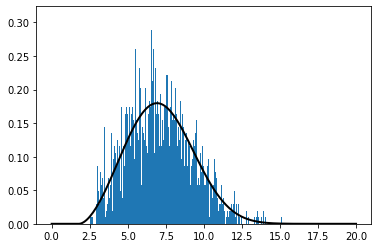

In [29]:
weibull_nov = weibull_min.fit(df_nov.WindSpeed) 
wnshape, wnloc, wnscale = weibull_nov[0], weibull_nov[1], weibull_nov[2]
dist_nov = weibull_min.pdf(x, wnshape, loc=wnloc,scale=wnscale) 

plt.plot(x, dist_nov, 'k-', lw=2, label='frozen pdf')
plt.hist(df_nov.WindSpeed, 400, density=True)
plt.show()

In [30]:
len(f_obs05)

183

In [31]:
wnmean = weibull_min(wnshape, loc=wnloc, scale=wnscale).mean()

In [32]:
#the chi-square critical value change due the chenge of the degrees of freedom
#lets see the actual p-value for this case
p_value = 1 - chi2.cdf(x=wnchisqr05, df=(len(f_obs05)-2-1))
print(p_value)

0.957307902532472


Low chi-square score for such amount of degrees of freedom.

# **NORMAL FIT**

## Importing the statistical function norm from scipy

In [33]:
from scipy.stats import norm

## Fitting the same data but in normal distribution

In [34]:
normal = norm.fit(df['WindSpeed'])
nmean, nsd = normal[0], normal[1]

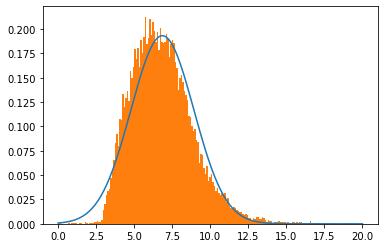

In [35]:
p = norm.pdf(x, nmean, nsd)
plt.plot(x, p)
plt.hist(df.WindSpeed, bins=200, density=True)
plt.show()

## Chi-square test

In [36]:
nf_exp = []
for a in range(1, len(df_test01.Windspeedbin), 1):
  nf_exp.append(norm.cdf(df_test01.iloc[a]['Windspeedbin'], nmean, nsd)-norm.cdf(df_test01.iloc[a-1]['Windspeedbin'], nmean, nsd))
nf_exp = [i*3192 for i in nf_exp]

In [37]:
nchisqr = 0
for i in range(0, len(nf_exp), 1):
  nchisqr = nchisqr + (f_obs[i]-nf_exp[i])**2/nf_exp[i]
nchisqr

610.2407146983874

Lets use november data to fit the curve

In [38]:
nnormal01 = norm.fit(df_nov['WindSpeed'])
nnmean, nnsd = nnormal01[0], nnormal01[1]

In [39]:
nf_exp = []
for a in range(1, len(df_test01.Windspeedbin), 1):
  nf_exp.append(norm.cdf(df_test01.iloc[a]['Windspeedbin'], nnmean, nnsd)-norm.cdf(df_test01.iloc[a-1]['Windspeedbin'], nnmean, nnsd))
nf_exp = [i*3192 for i in nf_exp]

In [40]:
nchisqr = 0
for i in range(0, len(nf_exp), 1):
  nchisqr = nchisqr + (f_obs[i]-nf_exp[i])**2/nf_exp[i]
nchisqr

264.5189257740384

In [41]:
nnormal01

(7.190216165413533, 2.132935657946973)

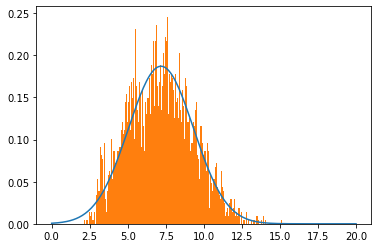

In [42]:
np = norm.pdf(x, nnmean, nnsd)
plt.plot(x, np)
plt.hist(df_nov.WindSpeed, bins=200, density=True)
plt.show()

Doing the same process and split the bins in half

In [43]:
nf_exp05 = []
for a in range(1, len(df_test05.Windspeedbin), 1):
  nf_exp05.append(norm.cdf(df_test05.iloc[a]['Windspeedbin'], nnmean, nnsd)-norm.cdf(df_test05.iloc[a-1]['Windspeedbin'], nnmean, nnsd))
nf_exp05 = [i*3192 for i in nf_exp05]


In [44]:
print(len(f_obs05), len(nf_exp05))

183 182


In [45]:
print(f_obs05[0], f_obs05[len(f_obs05)-1])

6 2


In [46]:
f_obs05.pop()

2

In [47]:
nchisqr05 = 0
for i in range(0, len(nf_exp05), 1):
  nchisqr05 = nchisqr05 + (f_obs05[i]-nf_exp05[i])**2/nf_exp05[i]
nchisqr05

294.1413521045471

##Prediction using ARMA model

In [48]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39195 entries, 0 to 39194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       39195 non-null  object 
 1   WindSpeed  39195 non-null  float64
 2   Power      39195 non-null  float64
dtypes: float64(2), object(1)
memory usage: 918.8+ KB


In [49]:
df_ar = df.copy()
df_ar ['Time'] = pd.to_datetime(df_ar['Time'], format='%Y%m%d %H:%M:%S')

(0.0, 36.0)

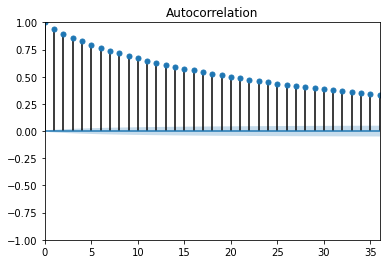

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['WindSpeed'])
plt.xlim(0, 36)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


(0.0, 36.0)

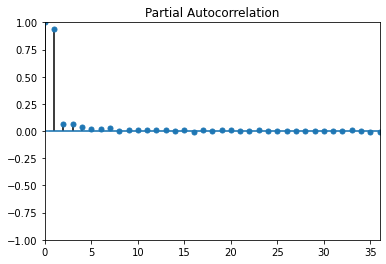

In [51]:
plot_pacf(df['WindSpeed'])
plt.xlim(0, 36)

In [52]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from statsmodels.tsa.arima.model import ARIMA

In [54]:
df_ar.set_index('Time', inplace=True)

In [98]:
ARIMA_model = ARIMA(df_ar.WindSpeed[:len(df_ar.WindSpeed*2/3)], order=(4, 0, 4)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


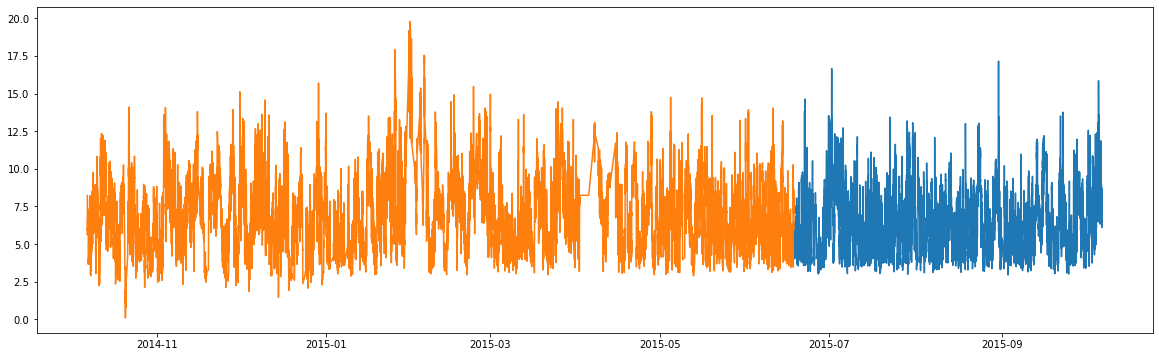

In [101]:
plt.figure(figsize=(20,6))
plt.plot(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])
plt.plot(df_ar.WindSpeed[:int(len(df_ar.WindSpeed)*2/3)])

In [100]:
ARIMA_test = ARIMA(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):], order=(4, 0, 4)).fit(ARIMA_model.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


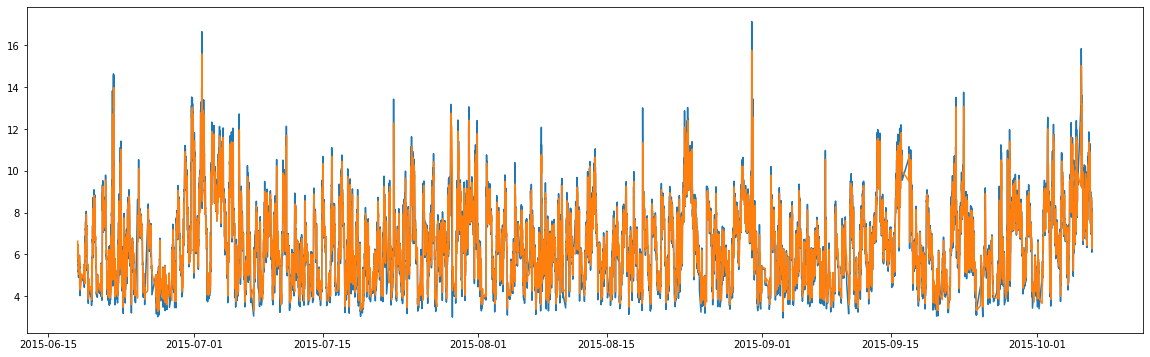

In [102]:
import datetime
plt.figure(figsize=(20,6))
plt.plot(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])
plt.plot(ARIMA_test.predict())

Comparing the Weibull, Normal and ARMA

In [103]:
werror = (((wnmean-df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])**2)**0.5/(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])).mean()
nerror = (((nnmean-df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])**2)**0.5/(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):])).mean()
armaerror = (((ARIMA_test.resid**2)**0.5/(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):]).shift(4)).dropna().mean())

In [104]:
print('Weibull error: {}\nNormal error: {} \nAIRMA error: {}'.format(werror,nerror,armaerror))

Weibull error: 0.2790506692562068
Normal error: 0.27896237226262205 
AIRMA error: 0.07712819234476315


In [86]:
parameters = []
for p in range (2, 6):
    for q in range(2,6):
      parameters.append([p, 0, q])

In [87]:
parameters

[[2, 0, 2],
 [2, 0, 3],
 [2, 0, 4],
 [2, 0, 5],
 [3, 0, 2],
 [3, 0, 3],
 [3, 0, 4],
 [3, 0, 5],
 [4, 0, 2],
 [4, 0, 3],
 [4, 0, 4],
 [4, 0, 5],
 [5, 0, 2],
 [5, 0, 3],
 [5, 0, 4],
 [5, 0, 5]]

In [88]:
arima_models = []
for i in parameters:
  arima_models.append(ARIMA(df_ar.WindSpeed[:len(df_ar.WindSpeed*2/3)], order=(i)).fit())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

In [93]:
arma_results = []
for i in range(0, len(arima_models)):
  arma_results.append(ARIMA(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):], order=(parameters[i])).fit(arima_models[i].params))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

In [94]:
resid = []
relative_error = []
for i in arma_results:
  resid.append(i.resid.dropna().mean())
  relative_error.append((((i.resid**2)**0.5/(df_ar.WindSpeed[int(len(df_ar.WindSpeed)*2/3):]).shift(4)).dropna().mean()))

In [96]:
relative_error

[0.07714440215519627,
 0.0771219860983214,
 0.07711835295666047,
 0.07711835725998305,
 0.07714060832284411,
 0.07711947905743026,
 0.07712354105959081,
 0.07712046969885136,
 0.07713249062641782,
 0.07711499292342769,
 0.07712819234476315,
 0.07712261366545355,
 0.07712096761892827,
 0.0771258504136092,
 0.07715960088233238,
 0.07713191198856065]

In [105]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from pmdarima.arima import auto_arima

In [107]:
aa = auto_arima(df_ar.WindSpeed)

In [108]:
aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                39195
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -40965.084
Date:                Fri, 15 Jul 2022   AIC                          81936.167
Time:                        02:54:10   BIC                          81961.896
Sample:                             0   HQIC                         81944.319
                              - 39195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9187      0.002    410.988      0.000       0.914       0.923
ma.L1         -0.9883      0.001  -1095.609      0.000      -0.990      -0.987
sigma2         0.4735      0.002    288.190      0.000       0.470       0.477
===================================================================================
Ljung-Box (L1) (Q):                  88.59   Jarque-Bera (JB):             79157.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.50
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
((aa.resid()**2)**0.5/(df_ar.WindSpeed).dropna()).mean()

0.0753596757440176